In [2]:
import pathlib
import numpy as np
import sys
import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import tensorboardX as tbx


%matplotlib inline

データファイルは次のように配置されている．

```
root_path
 |-numerai_datasets
    |-numerai_training_data.csv
    |-numerai_tournament_data.csv
```

In [ ]:
root_path = pathlib.Path('/Users/ryujihashimoto/Desktop/NUMERAI/')

def make_traintest_data(root_path, folder_name='numerai_datasets'):
    numerai_dataset_path = root_path / folder_name
    train_data_path = numerai_dataset_path / 'numerai_training_data.csv'
    test_data_path = numerai_dataset_path / 'numerai_tournament_data.csv'
    train_data = pd.read_csv(train_data_path).set_index('id')
    test_data = pd.read_csv(test_data_path).set_index('id')
    feature_names = [f for f in train_data.columns if "feature" in f]
    test_id = list(tournament_data.index)
    return train_data, test_data, feature_names, test_id

# ->　以後utils.make_traintest_dataから呼び出す

In [ ]:
train_data, test_data, feature_names, test_id = make_traintest_data(root_path)

## 1.データの観察

In [5]:
train_data

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n000315175b67977,era1,train,0.00,0.50,0.25,0.00,0.50,0.25,0.25,...,1.00,1.00,0.75,0.50,0.75,0.50,1.00,0.50,0.75,0.50
1,n0014af834a96cdd,era1,train,0.00,0.00,0.00,0.25,0.50,0.00,0.00,...,1.00,1.00,0.00,0.00,0.75,0.25,0.00,0.25,1.00,0.25
2,n001c93979ac41d4,era1,train,0.25,0.50,0.25,0.25,1.00,0.75,0.75,...,0.25,0.50,0.00,0.00,0.50,1.00,0.00,0.25,0.75,0.25
3,n0034e4143f22a13,era1,train,1.00,0.00,0.00,0.50,0.50,0.25,0.25,...,1.00,1.00,0.75,0.75,1.00,1.00,0.75,1.00,1.00,0.25
4,n00679d1a636062f,era1,train,0.25,0.25,0.25,0.25,0.00,0.25,0.50,...,0.75,0.75,0.25,0.50,0.75,0.00,0.50,0.25,0.75,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501803,nff6a8a8feaeeb52,era120,train,0.50,0.50,0.25,0.00,0.00,0.50,0.75,...,0.50,0.50,0.75,0.50,0.50,0.75,0.25,0.25,0.25,0.50
501804,nff6af62a0996372,era120,train,1.00,0.00,0.00,1.00,0.50,0.75,0.75,...,1.00,1.00,1.00,1.00,1.00,0.00,0.75,1.00,1.00,0.75
501805,nff9288983b8c040,era120,train,0.75,0.50,0.50,0.50,0.25,0.50,0.25,...,1.00,0.75,0.25,1.00,1.00,1.00,0.25,0.00,0.00,0.25
501806,nffaab4e1cacc4b1,era120,train,0.25,0.25,0.25,0.50,0.00,1.00,1.00,...,0.75,0.75,0.75,0.75,0.75,0.50,0.50,0.25,0.75,0.50


In [6]:
test_data

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n0003aa52cab36c2,era121,validation,0.25,0.75,0.50,0.50,0.0,0.75,0.50,...,0.75,0.75,1.00,0.75,0.50,0.5,1.00,0.00,0.00,0.25
1,n000920ed083903f,era121,validation,0.75,0.50,0.75,1.00,0.5,0.00,0.00,...,0.50,0.50,0.75,1.00,0.75,0.5,0.50,0.50,0.50,0.50
2,n0038e640522c4a6,era121,validation,1.00,0.00,0.00,1.00,1.0,1.00,1.00,...,0.00,0.00,0.50,0.25,0.00,0.0,0.50,0.50,0.00,1.00
3,n004ac94a87dc54b,era121,validation,0.75,1.00,1.00,0.50,0.0,0.00,0.00,...,0.00,0.00,0.00,0.25,0.00,0.0,0.00,0.25,0.25,0.50
4,n0052fe97ea0c05f,era121,validation,0.25,0.50,0.50,0.25,1.0,0.50,0.50,...,0.50,0.75,0.00,0.00,0.75,1.0,0.00,0.25,1.00,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1779475,nffd112483053b7a,eraX,live,0.50,0.25,0.50,1.00,1.0,1.00,1.00,...,0.00,0.00,0.00,0.00,0.75,1.0,0.00,0.00,0.00,NaN
1779476,nffda23fd6297b41,eraX,live,0.75,0.50,0.25,0.75,0.0,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,NaN
1779477,nffed587b72309c4,eraX,live,0.50,0.75,1.00,1.00,0.5,0.25,0.25,...,1.00,1.00,0.75,1.00,1.00,1.0,0.75,1.00,1.00,NaN
1779478,nffeda441259a613,eraX,live,1.00,0.75,0.50,1.00,1.0,1.00,1.00,...,0.50,0.00,0.50,0.50,0.00,0.0,0.00,0.50,0.00,NaN


各特徴量および目的値は0,0,25,0.5,0.75,1のいずれか．各特徴量でスケールは同じなので標準化は必要なさそう．また値は大小関係を持つためカテゴリ変数としてしまうのは適切でないが，値の間隔には意味がなさそうなのでより間隔を圧縮，拡大させることも考えられるかも．

### 1.1era毎のデータ数を描画

In [6]:
def count_samplesize_by_era(df, figsize=(15,5)):
    samplesize_series = df['era'].value_counts() 
    # 'era'列についてユニークな要素それぞれの出現回数を算出．
    # 参考：https://note.nkmk.me/python-pandas-value-counts/
    era_list = []
    samplesize_list = []
    
    # era_list=[1,2,3,...,120], samplesilze_list=[samplesize_series['era1'],...]とする．
    for i in range(1,121):
        era = f'era{i}'
        era_list.append(i)
        samplesize_list.append(samplesize_series[era])
    
    plt.figure(figsize=figsize)
    plt.bar(x=era_list, height=samplesize_list)
    plt.xlabel('era')
    plt.ylabel('sample size')
    plt.show()
    
    return samplesize_list

# -> 以後utils.preprocessから呼び出す

eraごとにサンプルサイズが等しくない．毎eraで違う銘柄(?)の特徴量が示されているっぽい．時系列をどのように扱えば良いのかが不明．

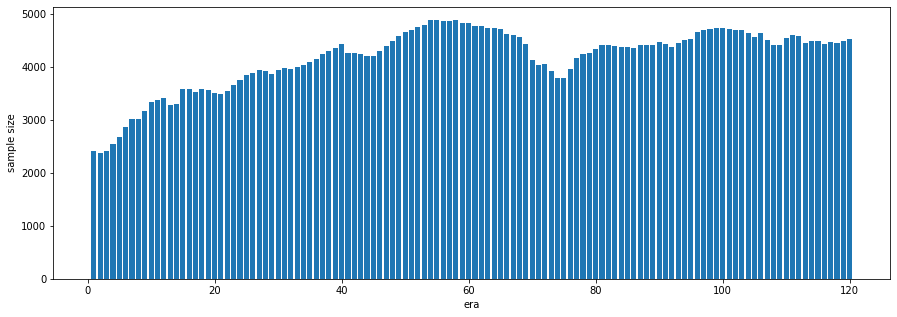

In [7]:
_ = count_samplesize_by_era(train_data)

### 1.2順位相関の計算

今回，データの数値が5種類しかないため値の順位がタイを多く持つことになる．そのような場合に順位相関を計算する時は計算に工夫が必要で，例えば，変数X,Yのデータが次のようであったとする，

| X | Y |
|---|---|
| 1 | 5 |
| 0 | 5 |
| 2 | 4 |
| 1 | 1 |
| 1 | 5 |
| 1 | 3 |

この時，タイ順位に対して出現順に

```
rank_X = [2,6,1,3,4,5]
rank_Y = [1,2,4,6,3,5]
```

と順位を振る方法では，相関係数が変数の並び順に影響を受けてしまう．そこで，タイ順位に対しては平等に順位の平均を割り当てる．例えば，Xの"1"という値は2~5位のため,その平均である3.5が順位として割り当てられる．従って，

```
rank_X = [3.5,6,1,3.5,3.5,3.5]
rank_Y = [2,2,3,6,2,5]
```

と順位をふり，順位相関は次のように計算できる．

```python
rank_x = np.array([3.5, 6, 1, 3.5, 3.5, 3.5])
rank_y = np.array([2, 2, 4, 6, 2, 5])
mean_x = np.mean(rank_x)
mean_y = np.mean(rank_y)
mean_xx = np.mean(rank_x*rank_x)
mean_yy = np.mean(rank_y*rank_y)
mean_xy = np.mean(rank_x*rank_y)
corr = (mean_xy - mean_x*mean_y) / (np.sqrt(mean_xx - mean_x**2)*np.sqrt(mean_yy - mean_y**2))
print(corr)
```

```python
###出力###
-0.35921060405354993
```


- 参考：[Spearman 相関係数を計算するときの注意点](https://qiita.com/PND/items/f368ebaee72df18dd10d)

In [5]:
def mean_rank(sorted_x, argsort_x):
    latest_value = sorted_x[0]
    latest_rank = 1
    same_value_rank_list = [argsort_x[0]] # タイ順位のリスト
    mean_rank_x = -np.ones_like(sorted_x).astype(np.float32)
    for i in range(1,len(sorted_x)):
        x = sorted_x[i]
        if x != latest_value:
            mean = (latest_rank + i) / 2 if i != 1 else 1
            mean_rank_x[same_value_rank_list] = mean
            latest_value = x
            latest_rank = i + 1
            same_value_rank_list = [argsort_x[i]]
        else:
            same_value_rank_list.append(argsort_x[i])
    mean = (latest_rank + len(sorted_x)) / 2
    mean_rank_x[same_value_rank_list] = mean
    
    return mean_rank_x

def calc_spearman_corr(x, y):
    
    #---
    # 配列を降順にソート
    #---
    
    sorted_x = -np.sort(-x)
    # 降順にするために-xをソートする
    sorted_y = -np.sort(-y)
    argsort_x = np.argsort(-x)
    argsort_y = np.argsort(-y)
    
    #---
    # 順位を算出
    #---
    
    rank_x = mean_rank(sorted_x, argsort_x)
    rank_y = mean_rank(sorted_y, argsort_y)
    
    
    #---
    # 順位相関係数を計算
    #---
    
    mean_x = np.mean(rank_x)
    mean_y = np.mean(rank_y)
    mean_xx = np.mean(rank_x*rank_x)
    mean_yy = np.mean(rank_y*rank_y)
    mean_xy = np.mean(rank_x*rank_y)
    corr = (mean_xy - mean_x*mean_y) / \
           (np.sqrt(mean_xx - mean_x**2)*np.sqrt(mean_yy - mean_y**2))
    
    return corr
    
# -> 以後utils.diagnosisから呼び出す

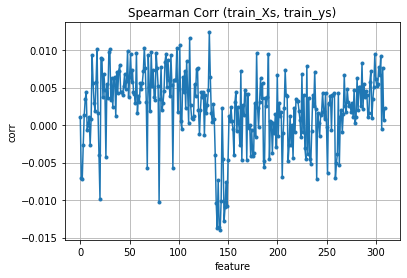

In [9]:
# 各特徴量と目的値との順位相関を計算 (train_data)
target = train_data['target'].values
features = train_data[feature_names].values
corr_arr = np.apply_along_axis(calc_spearman_corr, axis=0, 
                           arr=features, y=target)
fig, ax = plt.subplots()
ax.grid()
ax.plot(corr,
        marker='.', markersize=6)
ax.set_title('Spearman Corr (train_Xs, train_ys)')
ax.set(xlabel='feature', ylabel='corr')
plt.show()

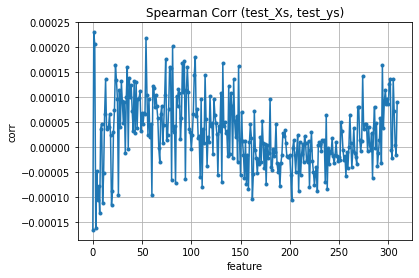

In [10]:
# 各特徴量と目的値との順位相関を計算 (test_data)
target = test_data['target'].values
features = test_data[feature_names].values
corr_arr = np.apply_along_axis(calc_spearman_corr, axis=0, 
                               arr=features, y=target)
fig, ax = plt.subplots()
ax.grid()
ax.plot(corr,
        marker='.', markersize=6)
ax.set_title('Spearman Corr (test_Xs, test_ys)')
ax.set(xlabel='feature', ylabel='corr')
plt.show()

上図からわかる通り目的値と有意な相関を持つ特徴量は存在しないようだが，とりあえず相関が0.005以上の特徴量を選んでデータセットを作り，ベースラインモデルを実装する．

## 2.データセットの作成


In [6]:
def choose_features(df, feature_names, threshold=0.005):
    highcorr_features = []
    target = df['target'].values
    features = df[feature_names].values
    corr_arr = np.apply_along_axis(calc_spearman_corr, axis=0, 
                                   arr=features, y=target)
    highcorr_idx = np.where(corr_arr > threshold)
    highcorr_arr = corr_arr[highcorr_idx]
    return highcorr_idx, highcorr_arr

In [8]:
highcorr_idx, highcorr_arr = choose_features(train_data, feature_names, 0.005)
highcorr_features = [feature_names[int(idx)] for idx in highcorr_idx[0]]
train_Xs = train_data[highcorr_features].values
train_ts = train_data['target'].values
test_Xs = test_data[highcorr_features].values
test_ts = test_data['target'].values
test_corr_arr = np.apply_along_axis(calc_spearman_corr, axis=0, 
                                    arr=test_Xs, y=test_ts)
print('Corr between feature and target (train/test)')
for i in range(len(highcorr_features)):
    feature = highcorr_features[i]
    train_corr = highcorr_arr[i]
    test_corr = test_corr_arr[i]
    print(f'[feature]{feature} [corr]({train_corr:.6f}/{test_corr:.6f})')

Corr between feature and target (train/test)
[feature]feature_charisma1 [corr](0.009310/0.000066)
[feature]feature_charisma2 [corr](0.005661/0.000136)
[feature]feature_charisma5 [corr](0.005696/0.000040)
[feature]feature_charisma6 [corr](0.010077/0.000066)
[feature]feature_charisma10 [corr](0.008991/0.000029)
[feature]feature_charisma11 [corr](0.008782/0.000074)
[feature]feature_charisma13 [corr](0.006794/0.000134)
[feature]feature_charisma16 [corr](0.005490/0.000114)
[feature]feature_charisma18 [corr](0.009736/0.000132)
[feature]feature_charisma19 [corr](0.010115/0.000093)
[feature]feature_charisma21 [corr](0.006236/0.000091)
[feature]feature_charisma23 [corr](0.006226/0.000100)
[feature]feature_charisma24 [corr](0.006398/0.000160)
[feature]feature_charisma26 [corr](0.007098/0.000139)
[feature]feature_charisma28 [corr](0.007219/0.000124)
[feature]feature_charisma29 [corr](0.007980/0.000072)
[feature]feature_charisma33 [corr](0.005262/0.000130)
[feature]feature_charisma34 [corr](0.0067

In [70]:
class dfDataset(Dataset):
    def __init__(self, Xs, ts, transforms=None):
        self.Xs = Xs
        self.ts = ts
        self.transforms = transforms
        
    def __len__(self):
        return len(self.Xs)
    
    def __getitem__(self, index):
        x = torch.from_numpy(self.Xs[index,:].astype(np.float32))
        t = torch.tensor(self.ts[index].astype(np.float32))
        if self.transforms is not None:
            x, t = self.transforms(x,t)
        return x, t
    
# -> 以後utils.preprocessから呼び出す

## 3.モデルの作成

In [78]:
class BaseLineModel(nn.Module):
    def __init__(self, input_dim):
        super(BaseLineModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 8)
        self.fc3 = nn.Linear(8, 1)
        
    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

## 4.訓練

In [85]:
def train(model_class, dataset_class, model_name, checkpoints_path, log_dir,
          fold_n, num_epoch, input_dim, device, transforms,
          train_Xs, train_ts,
          criterion):
    kf = KFold(n_splits=fold_n, shuffle=True, random_state=123)
    spl = kf.split(train_Xs)
    train_models = []
    train_model_paths = []
    print(f'[device]{device}')
    
    #---
    # fold
    #---
    
    for fold_i, (train_idx, val_idx) in enumerate(spl):
        
        train_losses = []
        train_corres = []
        val_losses = []
        val_corres = []
        
        print(f'[fold]{fold_i+1}/{fold_n}')
        print(f'[train_n]{len(train_idx)} [val_n]{len(val_idx)}')
        
        #---
        # dataset
        #---
        
        X_train = train_Xs[train_idx]
        t_train = train_ts[train_idx]
        X_val = train_Xs[val_idx]
        t_val = train_ts[val_idx]
        dataset_train = dataset_class(X_train, t_train, transforms)
        dataset_val = dataset_class(X_val, t_val, transforms)
        train_n = len(X_train)
        val_n = len(X_val)
        
        #---
        # dataloader
        #---
        
        dataloader_train = torch.utils.data.DataLoader(dataset_train,
                                                       batch_size=1000, shuffle=True)
        dataloader_val = torch.utils.data.DataLoader(dataset_val,
                                                     batch_size=1000, shuffle=False)
        
        #---
        # model, criterion, optimizer
        #---
        
        model = model_class(input_dim)
        model = model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        #---
        # TensorBoard
        #---
        
        writer = tbx.SummaryWriter(log_dir)
        
        #---
        # epoch
        #---
        
        tr_losses = []
        tr_corres = []
        val_losses = []
        val_corres = []
        for epoch in range(num_epoch):
            
            #---
            # train
            #---
            
            model.train()
            tr_loss = 0
            preds = []
            labels = []
            train_time_start = time.time()
            for step, batch in enumerate(dataloader_train):
                optimizer.zero_grad()
                bs = batch[0].shape[0]
                xs = batch[0].to(device)
                ts = batch[1].view(bs,1).to(device)
                ys = model(xs)
                loss = criterion(ys, ts)
                loss.backward()
                optimizer.step()
                tr_loss += (loss.item() * bs) / train_n
                preds.extend(ys.detach().cpu().numpy().tolist())
                labels.extend(ts.detach().cpu().numpy().tolist())
            preds = np.array(preds).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            tr_corr = calc_spearman_corr(preds[:,0], labels[:,0])
            tr_losses.append(tr_loss)
            tr_corres.append(tr_corr)
            train_time_end = time.time()
            train_time_total = train_time_end - train_time_start
                
            #---
            # val
            #---
            
            model.eval()
            val_loss = 0
            preds = []
            labels = []
            val_time_start = time.time()
            with torch.no_grad():
                for step, batch in enumerate(dataloader_val):
                    bs = batch[0].shape[0]
                    xs = batch[0].to(device)
                    ts = batch[1].view(bs,1).to(device)
                    ys = model(xs)
                    loss = criterion(ys, ts)
                    val_loss += (loss.item() * bs) / val_n
                    preds.extend(ys.detach().cpu().numpy().tolist())
                    labels.extend(ts.detach().cpu().numpy().tolist())
            preds = np.array(preds).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            val_corr = calc_spearman_corr(preds[:,0], labels[:,0])
            val_losses.append(val_loss)
            val_corres.append(val_corr)
            writer.add_scalars(f'Loss/fold{fold_i+1}',
                          {
                              'train': tr_loss,
                              'val': val_loss
                          }, epoch)
            writer.add_scalars(f'Corr/fold{fold_i+1}',
                          {
                              'train': tr_corr,
                              'val': val_corr
                          }, epoch)
            val_time_end = time.time()
            val_time_total = val_time_end - val_time_start
            total_time = train_time_total + val_time_total
            
            print(f'[epoch]{epoch+1}/{num_epoch}' +
                  f' [loss]tra:{tr_loss:.4f} val:{val_loss:.4f}' + 
                  f' [corr]tra:{tr_corr:.8f} val:{val_corr:.8f}' + 
                  f' [time]total:{total_time:.2f}sec' +
                  f' tra:{train_time_total}sec' +
                  f' val:{val_time_total}sec')
            
        #---
        # save model
        #---
        
        savename = f'{model_name}_epoch{num_epoch}_fold{fold_i+1}.pth'
        save_path = checkpoints_path / savename
        if not checkpoints_path.exists():
            checkpoints_path.mkdir(parents=True)
        torch.save(model.state_dict(), save_path)
        print(f'model saved to >> {save_path}')
        print()
        train_models.append(model)
        train_model_paths.append(save_path)
        writer.close()
        
        #---
        # display loss and corr
        #---
        
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.grid()
        ax1.plot(tr_losses, marker='.', markersize=6, color='red', label='train loss')
        ax1.plot(val_losses, marker='.', markersize=6, color='blue', label='val loss')
        ax2.plot(tr_corres, marker='.', markersize=6, color='green', label='train corr')
        ax2.plot(val_corres, marker='.', markersize=6, color='orange', label='val corr')
        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1+h2, l1+l2, loc = 'upper right')
        ax1.set(xlabel = 'Epoch', ylabel = 'Loss')
        ax2.set(ylabel = 'Corr')
        plt.show()
        
    return train_models, train_model_paths


[device]cpu
[fold]1/5
[train_n]401446 [val_n]100362
[epoch]1/22 [loss]tra:0.0513 val:0.0500 [corr]tra:0.01711249 val:0.02575645 [time]total:16.29sec tra:13.27120590209961sec val:3.0139498710632324sec
[epoch]2/22 [loss]tra:0.0500 val:0.0499 [corr]tra:0.02083399 val:0.02295024 [time]total:14.14sec tra:11.457940101623535sec val:2.679652214050293sec
[epoch]3/22 [loss]tra:0.0499 val:0.0499 [corr]tra:0.02194980 val:0.02436372 [time]total:13.18sec tra:10.876536130905151sec val:2.3012757301330566sec
[epoch]4/22 [loss]tra:0.0498 val:0.0498 [corr]tra:0.02516035 val:0.02682718 [time]total:20.78sec tra:16.376672983169556sec val:4.40431022644043sec
[epoch]5/22 [loss]tra:0.0498 val:0.0498 [corr]tra:0.02463453 val:0.02585697 [time]total:20.53sec tra:16.256471872329712sec val:4.269098997116089sec
[epoch]6/22 [loss]tra:0.0498 val:0.0498 [corr]tra:0.02686621 val:0.02588827 [time]total:24.76sec tra:20.309283018112183sec val:4.44956111907959sec
[epoch]7/22 [loss]tra:0.0498 val:0.0498 [corr]tra:0.03027627 

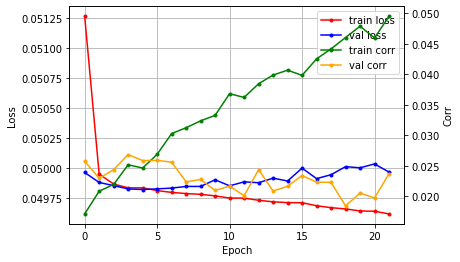

[fold]2/5
[train_n]401446 [val_n]100362
[epoch]1/22 [loss]tra:0.0666 val:0.0530 [corr]tra:0.02355059 val:0.02383598 [time]total:13.38sec tra:10.80730414390564sec val:2.5741870403289795sec
[epoch]2/22 [loss]tra:0.0512 val:0.0503 [corr]tra:0.02131220 val:0.02168092 [time]total:12.96sec tra:10.708881855010986sec val:2.2561097145080566sec
[epoch]3/22 [loss]tra:0.0501 val:0.0500 [corr]tra:0.01928155 val:0.02215606 [time]total:13.13sec tra:10.552735805511475sec val:2.578773021697998sec
[epoch]4/22 [loss]tra:0.0500 val:0.0518 [corr]tra:0.01819247 val:0.02241584 [time]total:13.22sec tra:10.910537958145142sec val:2.3072173595428467sec
[epoch]5/22 [loss]tra:0.0500 val:0.0500 [corr]tra:0.02020795 val:0.02001351 [time]total:13.24sec tra:10.643736124038696sec val:2.5969982147216797sec
[epoch]6/22 [loss]tra:0.0499 val:0.0501 [corr]tra:0.02024021 val:0.01813406 [time]total:12.96sec tra:10.708327293395996sec val:2.252030849456787sec
[epoch]7/22 [loss]tra:0.0499 val:0.0499 [corr]tra:0.02321333 val:0.01

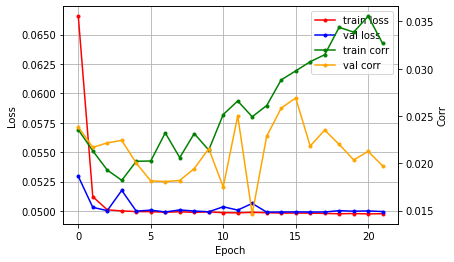

[fold]3/5
[train_n]401446 [val_n]100362
[epoch]1/22 [loss]tra:0.0500 val:0.0499 [corr]tra:0.01595386 val:0.02905986 [time]total:13.59sec tra:11.198042869567871sec val:2.3938090801239014sec
[epoch]2/22 [loss]tra:0.0498 val:0.0499 [corr]tra:0.02242458 val:0.02830755 [time]total:13.20sec tra:10.640264987945557sec val:2.564505100250244sec
[epoch]3/22 [loss]tra:0.0498 val:0.0500 [corr]tra:0.02484741 val:0.02392168 [time]total:12.97sec tra:10.700685977935791sec val:2.268036127090454sec
[epoch]4/22 [loss]tra:0.0498 val:0.0499 [corr]tra:0.02485264 val:0.02879033 [time]total:13.39sec tra:10.640216827392578sec val:2.7454519271850586sec
[epoch]5/22 [loss]tra:0.0498 val:0.0499 [corr]tra:0.02833997 val:0.03160245 [time]total:13.51sec tra:10.928438901901245sec val:2.5765810012817383sec
[epoch]6/22 [loss]tra:0.0498 val:0.0499 [corr]tra:0.03175981 val:0.03086034 [time]total:13.15sec tra:10.578386068344116sec val:2.572227954864502sec
[epoch]7/22 [loss]tra:0.0498 val:0.0499 [corr]tra:0.03189648 val:0.03

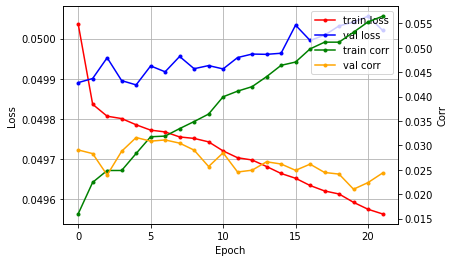

[fold]4/5
[train_n]401447 [val_n]100361
[epoch]1/22 [loss]tra:0.0824 val:0.0524 [corr]tra:0.01981329 val:0.02490469 [time]total:26.83sec tra:21.73526668548584sec val:5.09889817237854sec
[epoch]2/22 [loss]tra:0.0508 val:0.0498 [corr]tra:0.01923442 val:0.02211792 [time]total:24.86sec tra:20.04532790184021sec val:4.818446159362793sec
[epoch]3/22 [loss]tra:0.0502 val:0.0497 [corr]tra:0.01439191 val:0.01892466 [time]total:13.64sec tra:11.047480821609497sec val:2.593151092529297sec
[epoch]4/22 [loss]tra:0.0501 val:0.0497 [corr]tra:0.01522105 val:0.02134052 [time]total:15.70sec tra:11.712095022201538sec val:3.9866480827331543sec
[epoch]5/22 [loss]tra:0.0501 val:0.0499 [corr]tra:0.01560534 val:0.02063164 [time]total:13.33sec tra:10.717280149459839sec val:2.6135082244873047sec
[epoch]6/22 [loss]tra:0.0500 val:0.0496 [corr]tra:0.01788465 val:0.02049163 [time]total:14.49sec tra:12.215733051300049sec val:2.2738418579101562sec
[epoch]7/22 [loss]tra:0.0500 val:0.0497 [corr]tra:0.01686486 val:0.02561

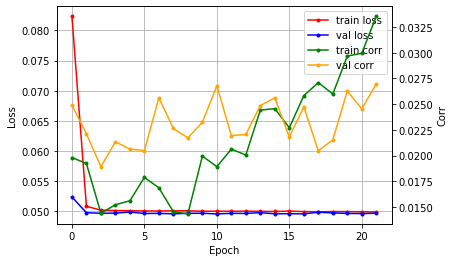

[fold]5/5
[train_n]401447 [val_n]100361
[epoch]1/22 [loss]tra:0.0600 val:0.0510 [corr]tra:0.02334070 val:0.02404078 [time]total:28.04sec tra:23.084798097610474sec val:4.956676244735718sec
[epoch]2/22 [loss]tra:0.0503 val:0.0502 [corr]tra:0.02333312 val:0.02127026 [time]total:26.71sec tra:21.384536027908325sec val:5.3238019943237305sec
[epoch]3/22 [loss]tra:0.0500 val:0.0500 [corr]tra:0.02208858 val:0.02275149 [time]total:26.63sec tra:21.74866485595703sec val:4.884253263473511sec
[epoch]4/22 [loss]tra:0.0499 val:0.0501 [corr]tra:0.02287603 val:0.02564515 [time]total:24.50sec tra:20.43536114692688sec val:4.06694769859314sec
[epoch]5/22 [loss]tra:0.0499 val:0.0507 [corr]tra:0.02393810 val:0.02593817 [time]total:13.19sec tra:10.824481964111328sec val:2.3609931468963623sec
[epoch]6/22 [loss]tra:0.0499 val:0.0501 [corr]tra:0.02428026 val:0.02715469 [time]total:13.15sec tra:10.862675905227661sec val:2.2847633361816406sec
[epoch]7/22 [loss]tra:0.0498 val:0.0500 [corr]tra:0.02498571 val:0.02743

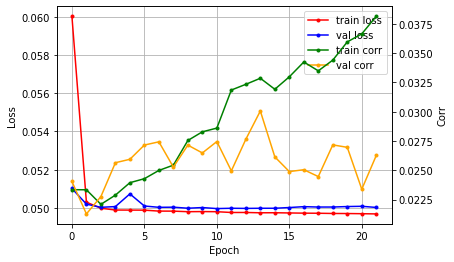

In [86]:
model_class = BaseLineModel
dataset_class = dfDataset
model_name = 'BaseLineModel'
checkpoints_path = root_path / 'checkpoints'
log_dir = root_path / 'log' / 'baselinemodels_experiment'
FOLD_N = 5
NUM_EPOCH = 22
input_dim = train_Xs.shape[1]
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
transforms = None
criterion = nn.MSELoss()

train_models, train_model_paths = train(model_class, dataset_class, 
                                        model_name, checkpoints_path, log_dir,
                                        FOLD_N, NUM_EPOCH, input_dim, device, transforms,
                                        train_Xs, train_ts,
                                        criterion)

In [ ]:
def submit(train_models, test_Xs, test_ts, dataset_class, test_id, 
           device, transforms,
           root_path, folder_name='numerai_datasets'):
    for model in train_models:
        model.eval()
        
    model_num = len(train_models)
    dataset_test = dataset_class(test_Xs, test_ts, transforms)
    dataloader_test = torch.utils.data.DataLoader(dataset_test,
                                                  batch_size=1000, shuffle=False)
    preds = []
    correct = 0
    
    with torch.no_grad():
        for step, batch in enumerate(dataloader_test):
            bs = batch[0].shape[0]
            xs = batch[0].to(device)
            _preds = np.zeros(bs).astype(np.float32)
            for model in train_models:
                model_preds = model(xs).detach().cpu().numpy()
                _preds += model_preds / model_num
            preds.extend(_preds.tolist())
    
    preds_df = pd.DataFrame({'id': test_id,
                             'prediction': preds})
    preds_csv_path = root_path / folder_name / 'preds.csv'
    preds_df.to_csv(preds_csv_path, index=False)